## Experiment 1
**Definition**: For the video character tracking problem, the face recognition network is provided with a video $V$ and $l$ labeled faces for each character of interest appearing in $V$ as the training data. In this experiment, the face recognition network is used as a face classifier to match each face in the testset to one character.

In [1]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
ROOT = Path.cwd().parent
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT)) 
if str(ROOT / 'track') not in sys.path:
    sys.path.append(str(ROOT / 'track')) 
if str(ROOT / 'track' / 'yolov5') not in sys.path:
    sys.path.append(str(ROOT / 'track' / 'yolov5'))
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn import TripletMarginLoss
from torch.utils.data import DataLoader
from facenet_pytorch import InceptionResnetV1
from recognition.dataset import TrainingSetLabeled, TrainingSetUnlabeled
from recognition.train import get_device, get_cosine_schedule_with_warmup, evaluate_accuracy
%matplotlib inline

In [2]:
def train_SSL(model, labeled_trainloader, unlabeled_trainloader, labeled_testloader, num_epochs, num_iters, learning_rate, threshold=0.95, useSSL=True):
    '''
    train_SSL:
        train the face recognition network using semi-supervised learning and triplet loss 
    inputs:
        model                 - face recognition model to be trained
        labeled_trainloader   - dataloader for the small labeled training set
        unlabeled_trainloader - dataloader for the unlabeled training set
        labeled_testloader    - dataloader for the large labeled test set
        num_epochs            - number of training epochs for semi-supervised learning and triplet-loss learning
        num_iters             - number of batches to be run for each epoch with batch_size = 8
        learning_rate         - learning rate
        threshold             - threshold value for generating pseudo labels
        useSSL                - whether to use unlabeled set during the training
    output: 
        accuracy_list         - list of accuracy after each training epoch (len=2*num_epochs)
    '''
    accuracy_list = []
    # params_1x: parameters with 1x learning rates
    params_1x = [param for name, param in model.named_parameters() if name not in ["logits.weight", "logits.bias"]]
    grouped_parameters = [
        {'params': params_1x, 'lr': learning_rate},
        {'params': model.logits.parameters(), 'lr': learning_rate*180}
    ]
    optimizer = torch.optim.SGD(grouped_parameters, lr=learning_rate, weight_decay=0.001)
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_epochs*num_iters)
    labeled_iter = iter(labeled_trainloader)
    unlabeled_iter = iter(unlabeled_trainloader)
    
    device = get_device()
    print(f'Use semi-supervised learning? {useSSL}')
    model.train()
    for epoch in range(num_epochs):
        for batch_idx in range(num_iters):
            # obtain the labeled batch
            try:
                inputs_x, targets_x = next(labeled_iter)
            except:
                labeled_iter = iter(labeled_trainloader)
                inputs_x, targets_x = next(labeled_iter)
            
            # obtain te unlabeled batch
            try:
                inputs_u, inputs_u_w = next(unlabeled_iter)
            except:
                unlabeled_iter = iter(unlabeled_trainloader)
                inputs_u, inputs_u_w = next(unlabeled_iter)
                
            num_x = inputs_x.shape[0] # number of labeled images in a batch
            num_u = inputs_u.shape[0] # number of unlabeled imaegs in a batch
            
            # obtain the outputs of the model
            inputs = torch.cat((inputs_x, inputs_u, inputs_u_w)).to(device)
            targets_x = targets_x.to(device)
            logits = model(inputs)
            
            # extract the logits
            logits_x = logits[:num_x]
            logits_u, logits_u_w = logits[num_x:].chunk(2)
            assert logits_u.shape[0] == num_u and logits_u_w.shape[0] == num_u
            del logits
            
            # Supervised loss
            Lx = F.cross_entropy(logits_x, targets_x, reduction='mean')
            
            # Semi-supervised loss
            pseudo_label = torch.softmax(logits_u.detach(), dim=-1)
            max_probs, targets_u = torch.max(pseudo_label, dim=-1)
            mask = max_probs.ge(threshold).float()
            
            total_sum = mask.sum().item()
            
            if total_sum > 0.5: 
                Lu = (F.cross_entropy(logits_u_w, targets_u, reduction='none')*mask).sum() / total_sum

            else:
                Lu = 0
            
            # total loss
            lambda_u = 1.0 if useSSL else 0.0
            loss = Lx + lambda_u * Lu            
            loss.backward()
            optimizer.step()
            scheduler.step()
            model.zero_grad()
        acc = evaluate_accuracy(model, labeled_testloader, get_device())[0]
        accuracy_list.append(acc)
        print(f"Semi Supevised Training - Epoch: [{epoch+1}/{num_epochs}] Accuracy: {acc:.3f}")
    
    # Triplet Loss Fine-tune
    print("Start Triplet Fine-Tuning......")
    model.classify = False
    params_1x = [param for name, param in model.named_parameters() if name not in ["logits.weight", "logits.bias"]]
    grouped_parameters = [
        {'params': params_1x, 'lr': learning_rate*20},
        {'params': model.logits.parameters(), 'lr': 0}
    ]
    optimizer = torch.optim.SGD(grouped_parameters, lr=learning_rate, weight_decay=0.001)
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_epochs*num_iters)
    
    triplet_loss = TripletMarginLoss(margin=1, p=2)
    device = get_device()
    model.classify = False
    model.eval()
    for epoch in range(num_epochs):
        labeled_iter = iter(labeled_trainloader)
        all_embeddings = None
        all_ys = None
        for X, y in labeled_iter:
            X = X.to(device)
            embedding = model(X)
            if all_embeddings is None:
                all_embeddings = embedding
                all_ys = y
            else:
                all_embeddings = torch.cat((all_embeddings, embedding))
                all_ys = torch.cat((all_ys, y))
        # Form the triplets: (anchor, positive, hard negative)
        anchor, positive, negative = None, None, None
        for idx, (e, y) in enumerate(zip(all_embeddings, all_ys)):
            min_neg_dist, min_neg = float('inf'), None
            pair_counter = 0
            for idx1, (e1, y1) in enumerate(zip(all_embeddings, all_ys)):
                if idx == idx1:
                    continue
                # Include all anchor-positive pairs
                if y == y1:
                    pair_counter += 1
                    if anchor is None:
                        anchor, positive = e.unsqueeze(0), e1.unsqueeze(0)
                    else:
                        anchor, positive = torch.cat((anchor, e.unsqueeze(0))), torch.cat((positive, e1.unsqueeze(0)))
                else:
                    curr_dist = (e-e1).norm().item()
                    if curr_dist < min_neg_dist:
                        min_neg_dist = curr_dist
                        min_neg = e1
            if negative is None:
                negative = torch.cat(tuple([min_neg.unsqueeze(0) for _ in range(pair_counter)]))
            else:
                negative = torch.cat((negative, torch.cat(tuple([min_neg.unsqueeze(0) for _ in range(pair_counter)]))))
        loss = triplet_loss(anchor, positive, negative)
        loss.backward()
        optimizer.step()
        scheduler.step()
        model.zero_grad()
        model.classify = True
        acc = evaluate_accuracy(model, labeled_testloader, get_device())[0]
        model.eval()
        model.classify = False
        print(f"Triplet Training - Epoch: [{epoch+1}/{num_epochs}] Accuracy: {acc:.3f}")
        accuracy_list.append(acc)
    return accuracy_list

In [3]:
def train(source, face_folder, test_folder, useSSL=True):
    '''
    train():
        This function is used to tune the pretrained face recognition network using the semi-supervised learning + triplet loss
    inputs:
        source: path to the video source
        face_folder: path to the face labeled set
        test_folder: path to the face test set
    NOTE: All images in the training set are in the RGB format!
    '''
    # Load small labeled dataset provided by the user
    print("Loading the labeled dataset......")
    LabeledTrainSet = TrainingSetLabeled(face_folder)
    LabeledTrainLoader = DataLoader(LabeledTrainSet, batch_size=8, shuffle=True)
    # Load unlabeled dataset obtained from the video
    print("Loading the unlabeled dataset......")
    UnlabeledTrainSet = TrainingSetUnlabeled(source, "data", num_images=2048)
    UnlabeledTrainLoader = DataLoader(UnlabeledTrainSet, batch_size=8*10, shuffle=True)
    # Load large labeled testset
    print("Loading the labeled testset......")
    LabeledTestSet = TrainingSetLabeled(test_folder, transform=False)
    LabeledTestLoader = DataLoader(LabeledTestSet, batch_size=8, shuffle=False)
    # Get the number of characters of interest
    num_classes = LabeledTrainSet.get_num_classes()
    # Load pretrained face recognition network
    fr_model = InceptionResnetV1(
        classify=True,
        pretrained='vggface2',
        num_classes=num_classes
    ).to(get_device())
    # Initialize the weight-parameters of the classification 
    nn.init.xavier_uniform_(fr_model.logits.weight)
    # Tune the face recognition network using semi-supervised training + triplet loss
    print("Start training the recognition network......")
    accuracy_list = train_SSL(fr_model, LabeledTrainLoader, UnlabeledTrainLoader, LabeledTestLoader, num_epochs=10, num_iters=40, learning_rate=1.5e-4, threshold=0.99, useSSL=useSSL)
    print("Finish training the recognition network......")
    return accuracy_list

**Experiment Details**

To do the experiments, you need to replace `source`, `face_folder`, `face_folder_1`, and `test_folder` to your own paths.

In [17]:
source = "../datasets/vct2/vct2.mp4"        # video link 
face_folder = "../datasets/vct2/face/"      # face folder containing 2 images / person
face_folder_1 = "../datasets/vct2/face1/"   # face folder containing 1 image / person
test_folder = "../datasets/vct2/test/"      # test images folder
accuracy_list_ssl_1_label = train(source, face_folder_1, test_folder, True)   # 1 label & semi-supervised learning
accuracy_list_sl_1_label = train(source, face_folder_1, test_folder, False)   # 1 label & supervised learning
accuracy_list_ssl_2_labels = train(source, face_folder, test_folder, True)    # 2 labels & semi-supervised learning
accuracy_list_sl_2_labels = train(source, face_folder, test_folder, False)    # 2 labels & supervised learning

Loading the labeled dataset......
Loading the unlabeled dataset......
Loading the labeled testset......
Start training the recognition network......
Use semi-supervised learning? True
Semi Supevised Training - Epoch: [1/10] Accuracy: 0.730
Semi Supevised Training - Epoch: [2/10] Accuracy: 0.754
Semi Supevised Training - Epoch: [3/10] Accuracy: 0.776
Semi Supevised Training - Epoch: [4/10] Accuracy: 0.783
Semi Supevised Training - Epoch: [5/10] Accuracy: 0.805
Semi Supevised Training - Epoch: [6/10] Accuracy: 0.814
Semi Supevised Training - Epoch: [7/10] Accuracy: 0.842
Semi Supevised Training - Epoch: [8/10] Accuracy: 0.858
Semi Supevised Training - Epoch: [9/10] Accuracy: 0.868
Semi Supevised Training - Epoch: [10/10] Accuracy: 0.869
Start Triplet Fine-Tuning......
Triplet Training - Epoch: [1/10] Accuracy: 0.877
Triplet Training - Epoch: [2/10] Accuracy: 0.869
Triplet Training - Epoch: [3/10] Accuracy: 0.866
Triplet Training - Epoch: [4/10] Accuracy: 0.881
Triplet Training - Epoch: [

In [18]:
def plot_line(x, Y, labels, title, xlabel, ylabel, save_path, ylim, figsize=(15, 6)):
    fig, ax = plt.subplots(figsize=(8,5))
    plt.rcParams["font.size"] = 13
    colors = ['hotpink', 'turquoise', 'limegreen', 'mediumpurple']
    colors_dark = ['deeppink', 'lightseagreen', 'forestgreen', 'blueviolet']
    # Turn on the grids
    plt.grid(visible=True, which='major', linestyle='-')
    plt.grid(visible=True, which='major', linestyle='--', alpha=0.5)
    plt.minorticks_on()
    # Add the patch
    poly_coords = [(10, ylim[0]), (20, ylim[0]), (20, ylim[1]), (10, ylim[1])]
    ax.add_patch(plt.Polygon(poly_coords, color ='gray', alpha = 0.3)) 
    # Start the plot
    for i in range(len(Y)):
        plt.plot(x, Y[i], 'o-.', color=colors[i], label=labels[i], linewidth=1)
#         plt.plot([10, 11], Y[i][9:11], 'o-', color=colors_dark[i], linewidth=1) # highlight transition from ssl to triplet loss
    plt.title(title), plt.xlabel(xlabel, fontsize=15), plt.ylabel(ylabel, fontsize=15), plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xticks(x)    
    plt.ylim(ylim[0], ylim[1])
    plt.xlim(0.5, 0.5+len(x))
#     plt.savefig(save_path)
    plt.show()

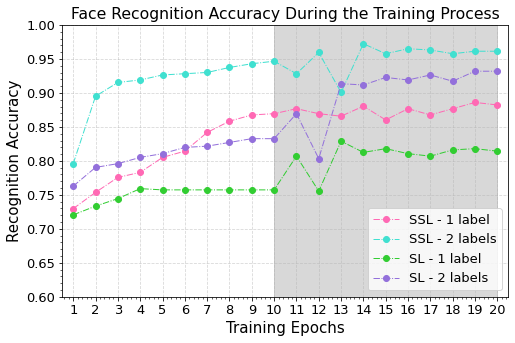

In [19]:
x = [i+1 for i in range(len(accuracy_list_sl_2_labels))]
Y = [accuracy_list_ssl_1_label, accuracy_list_ssl_2_labels, accuracy_list_sl_1_label, accuracy_list_sl_2_labels]
labels = ['SSL - 1 label', 'SSL - 2 labels', 'SL - 1 label', 'SL - 2 labels']
title = "Face Recognition Accuracy During the Training Process"
xlabel, ylabel = "Training Epochs", "Recognition Accuracy"
save_path = None
plot_line(x, Y, labels, title, xlabel, ylabel, save_path, ylim=(0.6, 1), figsize=(12, 6))